# [G6]-프로젝트: 자율주행 보조 시스템 만들기

## 1. 자율주행 시스템 만들기  
  
위에서 만든 모델을 통해 아래의 조건을 만족하는 함수를 만들어 주세요.  
  
* 입력으로 이미지 경로를 받습니다.  
* 정지조건에 맞는 경우 "Stop" 아닌 경우 "Go"를 반환합니다.  
* 조건은 다음과 같습니다. (=정지 조건)  
    - 사람이 한 명 이상 있는 경우  
    - 차량의 크기(width or height)가 300px이상인 경우  

In [1]:
# img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'

# def self_drive_assist(img_path, size_limit=300):
#     # 코드 구현
#         # 정지조건에 맞으면 return "Stop"
#         # 아닌 경우 return "Go"

# print(self_drive_assist(img_path))    

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

In [3]:
import tensorflow_datasets as tfds
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

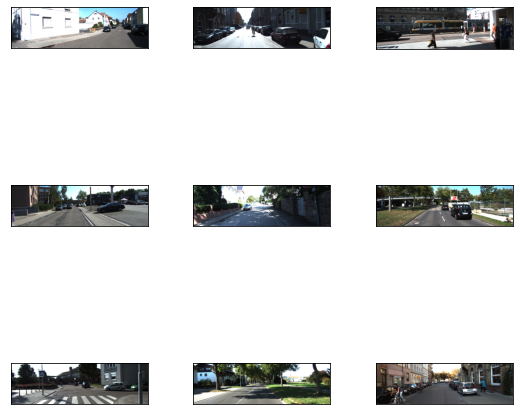

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

In [5]:
ds_info

tfds.core.DatasetInfo(
    name='kitti',
    full_name='kitti/3.2.0',
    description="""
    Kitti contains a suite of vision tasks built using an autonomous driving
    platform. The full benchmark contains many tasks such as stereo, optical flow,
    visual odometry, etc. This dataset contains the object detection dataset,
    including the monocular images and bounding boxes. The dataset contains 7481
    training images annotated with 3D bounding boxes. A full description of the
    annotations can be found in the readme of the object development kit readme on
    the Kitti homepage.
    """,
    homepage='http://www.cvlibs.net/datasets/kitti/',
    data_path='/home/aiffel-dj42/tensorflow_datasets/kitti/3.2.0',
    download_size=11.71 GiB,
    dataset_size=5.27 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/file_name': Text(shape=(), dtype=tf.string),
        'objects': Sequence({
            'alpha': tf.float32,
    

- 데이터셋 개수: (train=6347, test=711, valid=423)
- 라벨 분석
  - alpha: 물체의 관찰 각도 (카메라 각도) [-pi..pi]
  - bbox: 각 이미지에 대한 2D bounding box (우상단, 좌하단 좌표)
  - dimensions: 3D 물체에 대한 height, width, length
  - location: 3D 물체에 대한 위치: x, y, z
  - occluded: 보이는 정도? 0=완전 보임, 1=부분적으로 보임, 2=거의 안보임, 3=알 수 없음
  - rotation_y: 카메라 좌표 [-pi..pi]에서 Y축을 중심으로 회전
  - truncated: 물체의 잘림 정도, 0=잘리지 않음, 1=잘림
  - type: 객체의 유형에 대한 설명 '자동차', '밴', '트럭', '보행자', '앉은 사람', '자전거 타는 사람', '운반차' 등등

In [6]:
TakeDataset = ds_train.take(1)

--Example--
['image', 'image/file_name', 'objects']
--objects--
{'alpha': <tf.Tensor: shape=(10,), dtype=float32, numpy=
array([-1.66,  0.25, -2.79, -0.35, -2.72, -2.73,  0.57,  0.7 , -0.73,
       -0.93], dtype=float32)>, 'bbox': <tf.Tensor: shape=(10, 4), dtype=float32, numpy=
array([[0.42536   , 0.5121417 , 0.51178664, 0.54883254],
       [0.39682665, 0.28924316, 0.52290666, 0.3950644 ],
       [0.32474667, 0.1942029 , 0.50616   , 0.34513688],
       [0.33773333, 0.6083736 , 0.5160533 , 0.75545895],
       [0.29904   , 0.13387279, 0.5044    , 0.3169807 ],
       [0.23946667, 0.05114332, 0.54770666, 0.29162642],
       [0.16064   , 0.        , 0.49984   , 0.26651368],
       [0.02730667, 0.        , 0.4808    , 0.21529791],
       [0.07216   , 0.80185187, 0.51338667, 0.99919486],
       [0.00266667, 0.92387277, 0.47234666, 0.99919486]], dtype=float32)>, 'dimensions': <tf.Tensor: shape=(10, 3), dtype=float32, numpy=
array([[1.32, 1.63, 4.1 ],
       [1.58, 1.56, 4.25],
       [1.5 , 1

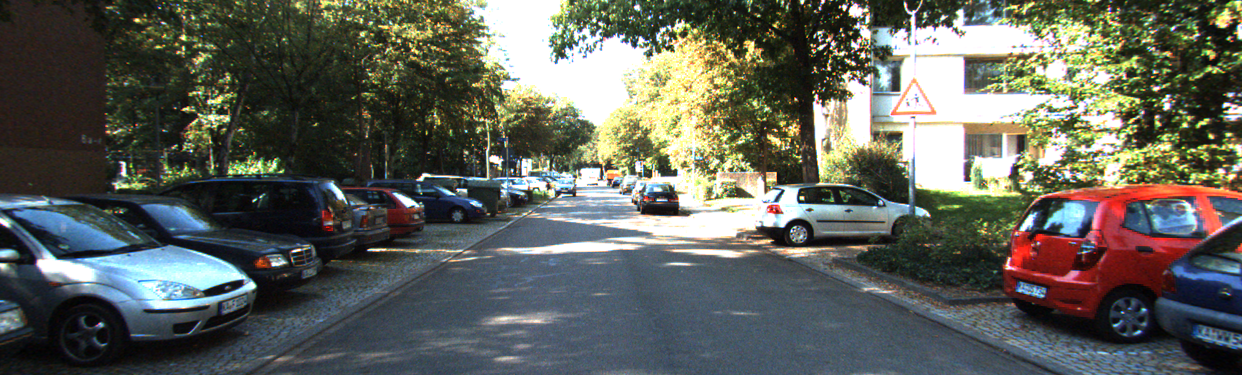

In [7]:
for example in TakeDataset:  
    print('--Example--')
    print(list(example.keys())) # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
    image = example["image"]
    filename = example["image/file_name"].numpy().decode('utf-8')
    objects = example["objects"]

print('--objects--')
print(objects)
img = Image.fromarray(image.numpy())
img

#### 6-3 의 x_min/max, y_min/max 찍어보면서 이해하기

1242 375
(10, 4)


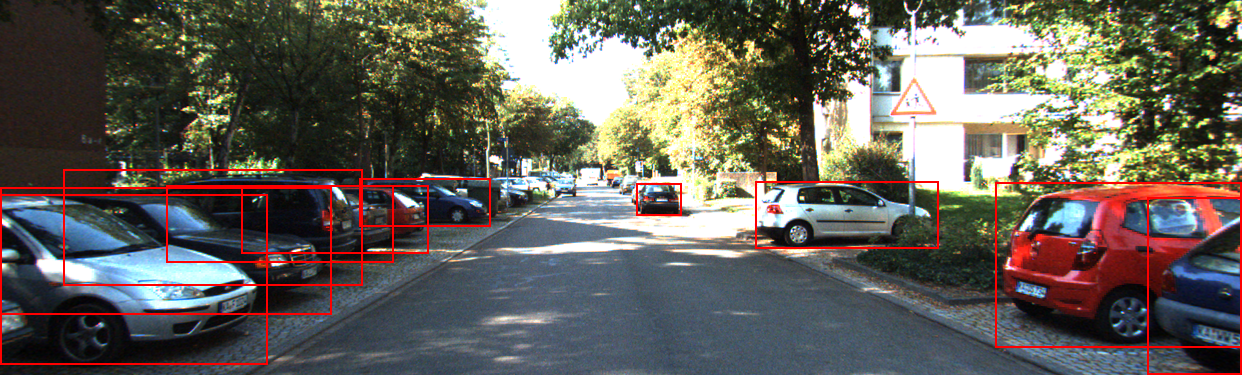

In [8]:
def visualize_bbox(input_image, object_bbox):
    input_image = copy.deepcopy(input_image)
    draw = ImageDraw.Draw(input_image)

    # 바운딩 박스 좌표(x_min, x_max, y_min, y_max) 구하기
    width, height = img.size
    print(width, height)
    print(object_bbox.shape)
    x_min = object_bbox[:,1] * width # 전체 행의 1번째 열 # *width는 비율 
    x_max = object_bbox[:,3] * width # 전체 행의 3번째 열
    y_min = height - object_bbox[:,0] * height # height에서 빼주는 이유는 사진의 좌측상단 끝점이 (0,0)임
    y_max = height - object_bbox[:,2] * height
    
    # 바운딩 박스 그리기
    rects = np.stack([x_min, y_min, x_max, y_max], axis=1)
    for _rect in rects:
        draw.rectangle(_rect, outline=(255,0,0), width=2)
    return input_image

visualize_bbox(img, objects['bbox'].numpy())

## 클래스 및 바운딩 박스 정보 추출

In [9]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)

    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)
        
        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size
        
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height
        
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df
    
df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [13:12<00:00,  8.00it/s]


In [10]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:32<00:00,  7.66it/s]


In [11]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

* 텐서플로우와 케라스 버전 안맞을 때 해결 : https://wikidocs.net/94660

In [12]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv ~/aiffel/object_detection/data/kitti_train.csv ~/aiffel/object_detection/data/classes.txt

2021-04-26 23:03:56.348854: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-26 23:03:57.415173: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-26 23:03:57.439663: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2021-04-26 23:03:57.439692: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aiffeldj42-ROG-Strix-G712LW-G712LW
2021-04-26 23:03:57.439698: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aiffeldj42-ROG-Strix-G712LW-G712LW
2021-04-26 23:03:57.439751: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 450.119.3
2021-04-26 23:03:57.439769: I tensorflow/stream_executor/cuda/cuda_diagnostics.c

Epoch 1/50
2021-04-26 23:04:02.222189: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 18874368 exceeds 10% of free system memory.
2021-04-26 23:04:02.269204: W tensorflow/core/framework/cpu_allocator_impl.cc:81] Allocation of 18874368 exceeds 10% of free system memory.
195/195 [==============================] - ETA: 0s - loss: 3.4606 - regression_loss: 2.6322 - classification_loss: 0.8284
Epoch 00001: saving model to ./snapshots/resnet50_csv_01.h5
195/195 [==============================] - 863s 4s/step - loss: 3.4606 - regression_loss: 2.6322 - classification_loss: 0.8284
Epoch 2/50
 22/195 [==>...........................] - ETA: 12:27 - loss: 2.9533 - regression_loss: 2.3838 - classification_loss: 0.5696

In [13]:
!python ~/aiffel/object_detection/keras-retinanet/keras_retinanet/bin/convert_model.py ./snapshots/resnet50_csv_10.h5 ./snapshots/resnet50_csv_50_infer.h5

2021-04-26 23:20:17.548834: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-26 23:20:19.127307: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-26 23:20:19.164676: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2021-04-26 23:20:19.164759: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: aiffeldj42-ROG-Strix-G712LW-G712LW
2021-04-26 23:20:19.164779: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: aiffeldj42-ROG-Strix-G712LW-G712LW
2021-04-26 23:20:19.165176: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 450.119.3
2021-04-26 23:20:19.165248: I tensorflow/stream_executor/cuda/cuda_diagnostics.c

In [14]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

model_path = os.path.join('.', 'snapshots', 'resnet50_csv_50_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

#### node 6-7 참고

[591.36884 176.03319 622.501   201.6128 ]
[191.3127  130.97935 326.7309  231.40753]


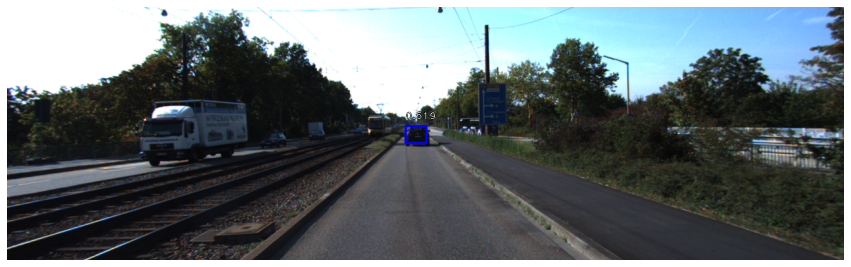

In [15]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy() # 박스 만들기 위한 변수
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB) # bgr을 rgb로 바꿈

    color_map = {
        0: (0, 0, 255), # blue (car)
        1: (255, 0, 0) # red (person)
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image ## 아래의 것들은 리스트
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5: # 내가 보고 싶은 근방에서만 차 인식하기
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label]) 
# 라벨0=차, 라벨1=사람
            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path=img_path)

[778.1629  146.46986 837.81244 320.31754]
[766.03253 153.97447 853.2916  312.64926]


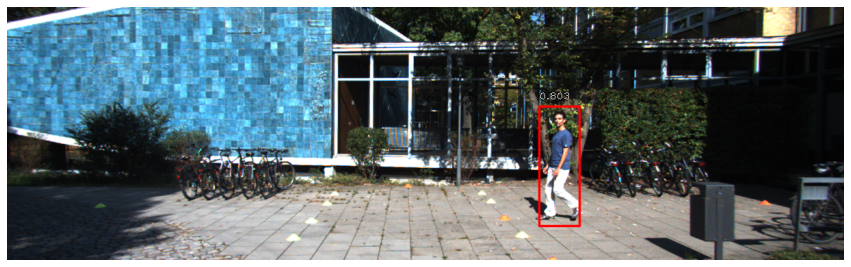

In [16]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path=img_path)

In [17]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_3.png'

def self_drive_assist(img_path, size_limit=300):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale
    
    
    ## 중요!! ## 박스와 스코어 이해하기!!! 스코어를 어떻게 주냐에 따라 인식하는 정도가 달라짐
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # 만약 사람이 1명 이상이면 멈춘다.
        if label == 1:
            return "Stop"
        # 자동차가 있는 경우
        elif label == 0:
            width = box[2] - box[0] # 그냥 절댓값으로 계산해도 됨 abs(box[2] - box[0])
            height = box[3] - box[1]
            # 사람이 아닌 경우 width와 height 둘 중 하나가 300 이상이면 'Stop'
            if width >= 300 or height >= 300:
                return "Stop"
        # 둘다 아니라면 그냥 간다.    
        if score < 0.5:
            return "Go"

print(self_drive_assist(img_path)) 

Go


## 2. 자율주행 시스템 평가하기  
  
아래 `test_system()` 를 통해서 위에서 만든 함수를 평가해봅시다. 10장에 대해 Go와 Stop을 맞게 반환하는지 확인하고 100점 만점으로 평가해줍니다.

In [24]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    win = 0
    total = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        print(image_path)
        result = self_drive_assist(img_path=image_path, size_limit=300)
        total += 1
        if result == answer:
            score += 10
            win += 1
    print(f"총 {total}장 중에서 {win}개를 맞췄으므로, {score}점입니다.")

In [25]:
test_system(self_drive_assist)

/home/aiffel-dj42/aiffel/object_detection/test_set/stop_1.png
/home/aiffel-dj42/aiffel/object_detection/test_set/stop_2.png
/home/aiffel-dj42/aiffel/object_detection/test_set/stop_3.png
/home/aiffel-dj42/aiffel/object_detection/test_set/stop_4.png
/home/aiffel-dj42/aiffel/object_detection/test_set/stop_5.png
/home/aiffel-dj42/aiffel/object_detection/test_set/go_1.png
/home/aiffel-dj42/aiffel/object_detection/test_set/go_2.png
/home/aiffel-dj42/aiffel/object_detection/test_set/go_3.png
/home/aiffel-dj42/aiffel/object_detection/test_set/go_4.png
/home/aiffel-dj42/aiffel/object_detection/test_set/go_5.png
총 10장 중에서 10개를 맞췄으므로, 100점입니다.
